<a href="https://colab.research.google.com/github/Mosl29/PC2/blob/main/CDC040_CNN_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

KeyboardInterrupt: ignored

In [ ]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [ ]:
# get the "features" portion of VGG19 ("classifier" portion is not needed)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
# move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
def load_image(img_path, max_size=400, shape=None):
    '''Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])
    
    # discard the transparent, alpha channels (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [ ]:
# ****************************** HERE YOU CAN CHANGE YOUR CONTENT AND STYLES IMAGES ***********************************************
# load in content and style images
content = load_image('/gdrive/MyDrive/CDC040 The Predictive Mind/images/ironman.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('/gdrive/MyDrive/CDC040 The Predictive Mind/images/delaunay.jpg', shape=content.shape[-2:]).to(device)

In [ ]:
# helper function for un-normalizing an image and 
#converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    '''Display a tensor as an image'''
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    return image

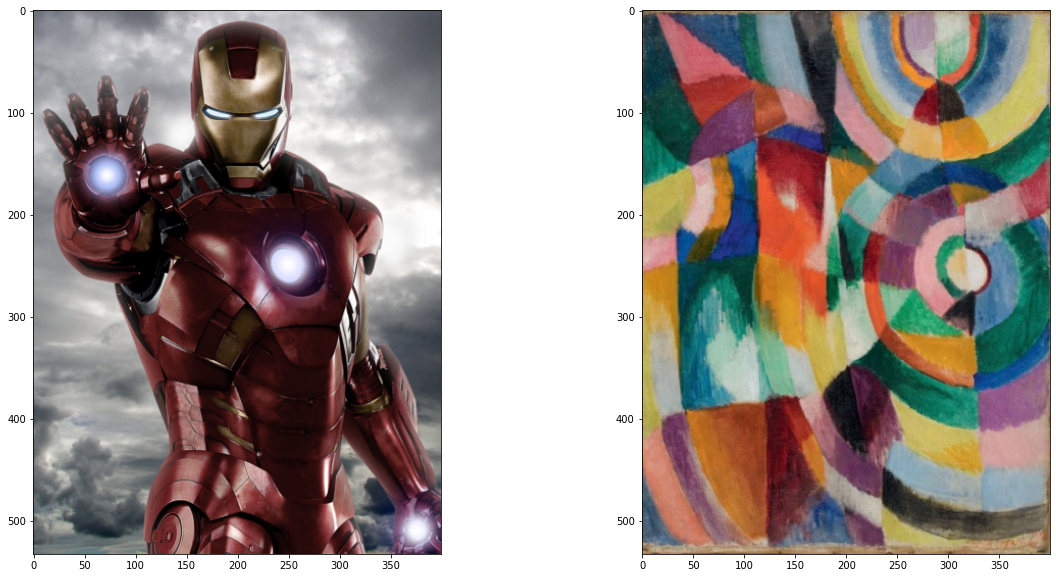

In [ ]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [ ]:
def get_features(image, model, layers=None):
    '''Run an image forward through a model and get the features for 
    a set of layers. Default layers are for VGGNet matching Gatys et al (2016)'''
    
    ## Mapping layer names, layers needed for content and style representation of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                 '5': 'conv2_1',
                 '10': 'conv3_1',
                 '19': 'conv4_1',
                 '21': 'conv4_2',
                 '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [ ]:
def gram_matrix(tensor):
    '''Claculate the Gram Matrix of a given tensor
    Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix'''
    
    ## get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    ## reshape it, so we're multiplying the features for each channel
    tensor = tensor.view(d, h*w)
    
    ## calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [ ]:
# get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start-off with the target as a copy of *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [ ]:
# weights for each style layer
# weighting earlier layers more will result in *larger* style artifacts
# notice here excluding `conv4_2` content representation
style_weights = {'conv1_1': 1.,
                'conv2_1': 0.75,
                'conv3_1': 0.2,
                'conv4_1': 0.2,
                'conv5_1': 0.2}

# content and style weight
content_weight = 1 # alpha
style_weight = 1e6 # beta

Image of iteration  100
Total loss:  33659544.0


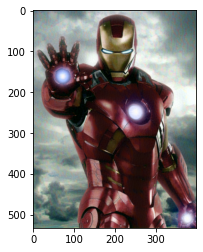

Image of iteration  200
Total loss:  18666062.0


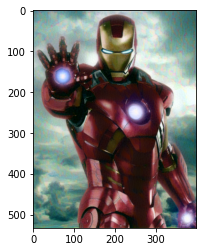

Image of iteration  300
Total loss:  10768570.0


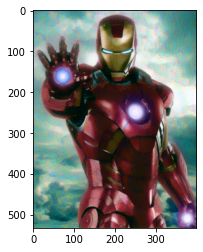

Image of iteration  400
Total loss:  7710251.0


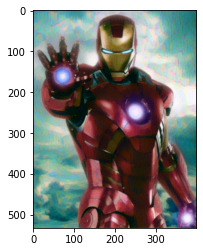

Image of iteration  500
Total loss:  5992284.0


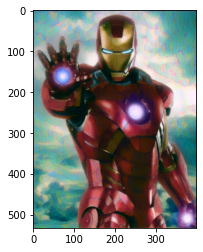

Image of iteration  600
Total loss:  4785341.0


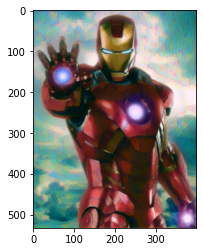

Image of iteration  700
Total loss:  3878959.75


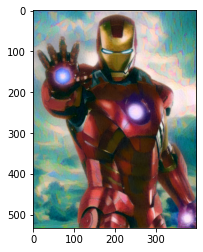

Image of iteration  800
Total loss:  3173226.75


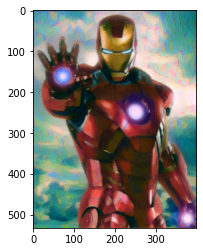

Image of iteration  900
Total loss:  2611979.25


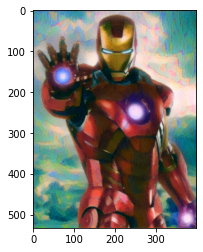

Image of iteration  1000
Total loss:  2160219.0


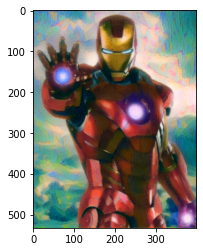

Image of iteration  1100
Total loss:  1794782.625


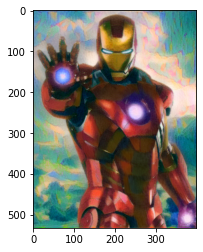

Image of iteration  1200
Total loss:  1498200.125


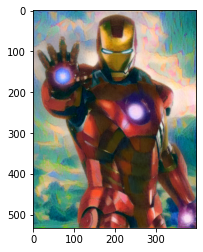

Image of iteration  1300
Total loss:  1256775.125


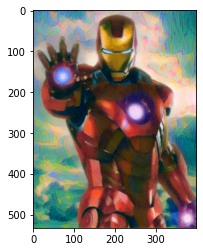

Image of iteration  1400
Total loss:  1059490.875


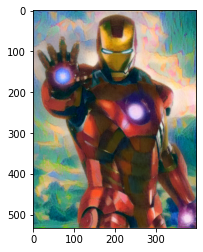

Image of iteration  1500
Total loss:  898113.625


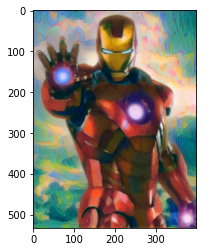

Image of iteration  1600
Total loss:  765905.875


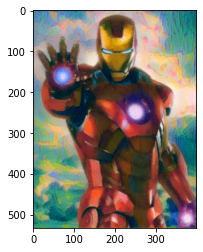

Image of iteration  1700
Total loss:  657456.625


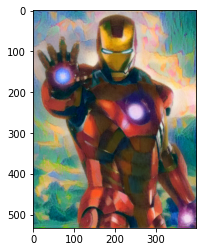

Image of iteration  1800
Total loss:  568358.0625


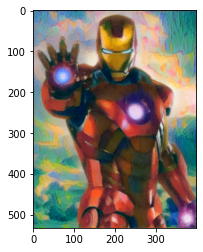

Image of iteration  1900
Total loss:  495268.5625


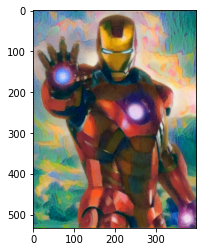

Image of iteration  2000
Total loss:  435061.6875


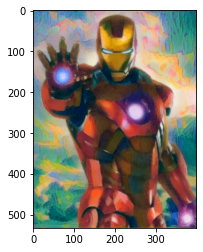

Image of iteration  2100
Total loss:  385158.3125


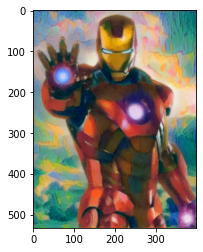

Image of iteration  2200
Total loss:  343574.09375


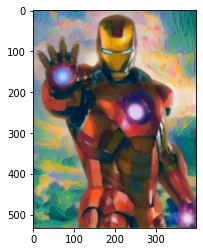

Image of iteration  2300
Total loss:  308655.375


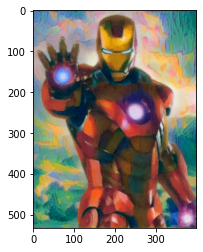

Image of iteration  2400
Total loss:  279075.28125


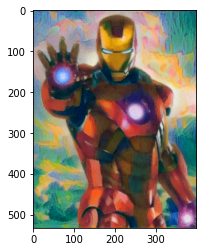

Image of iteration  2500
Total loss:  253818.875


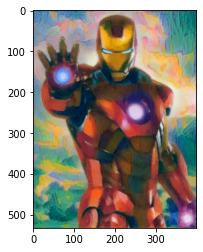

Image of iteration  2600
Total loss:  232123.84375


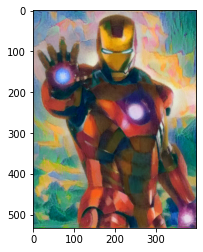

Image of iteration  2700
Total loss:  213302.84375


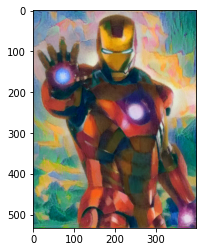

Image of iteration  2800
Total loss:  196944.65625


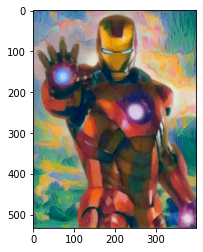

Image of iteration  2900
Total loss:  182614.578125


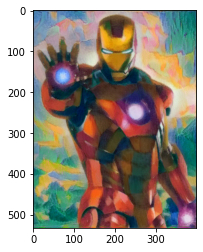

Image of iteration  3000
Total loss:  170009.484375


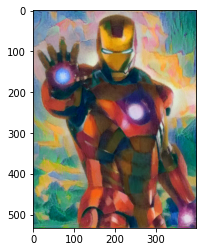

Image of iteration  3100
Total loss:  158829.078125


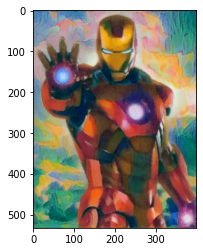

Image of iteration  3200
Total loss:  148878.703125


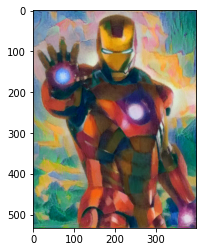

Image of iteration  3300
Total loss:  139943.453125


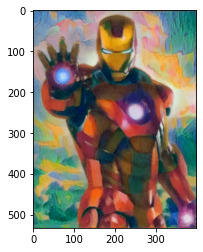

Image of iteration  3400
Total loss:  131862.328125


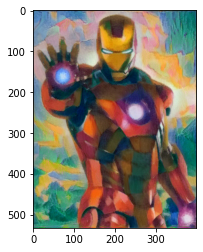

Image of iteration  3500
Total loss:  124559.5625


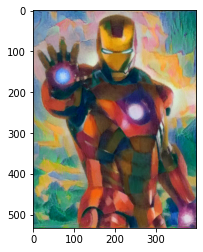

Image of iteration  3600
Total loss:  117935.7109375


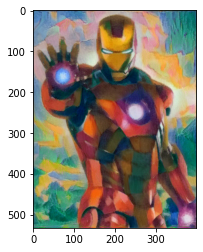

Image of iteration  3700
Total loss:  111888.2421875


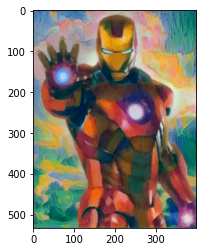

Image of iteration  3800
Total loss:  106336.9921875


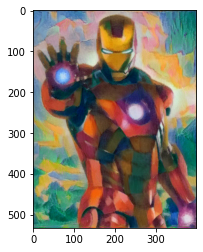

Image of iteration  3900
Total loss:  101228.6328125


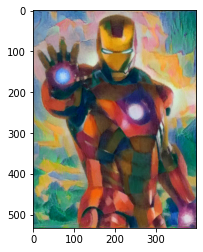

Image of iteration  4000
Total loss:  96522.515625


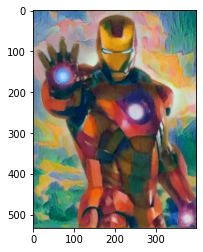

Image of iteration  4100
Total loss:  92180.9921875


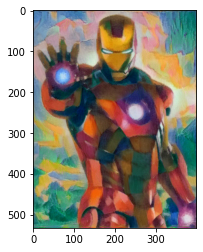

Image of iteration  4200
Total loss:  88145.0859375


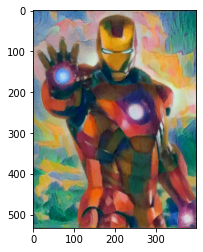

Image of iteration  4300
Total loss:  84382.4453125


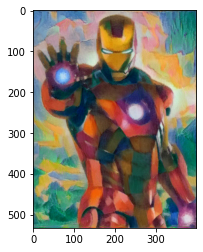

Image of iteration  4400
Total loss:  80883.2578125


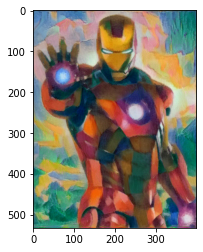

Image of iteration  4500
Total loss:  77636.984375


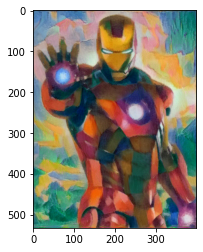

Image of iteration  4600
Total loss:  74603.2578125


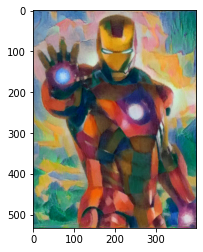

Image of iteration  4700
Total loss:  71770.0234375


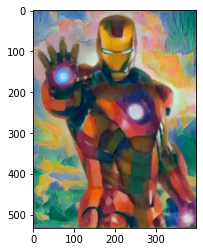

Image of iteration  4800
Total loss:  69110.890625


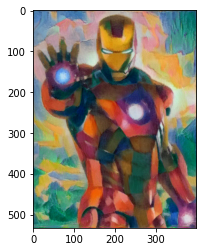

Image of iteration  4900
Total loss:  66603.578125


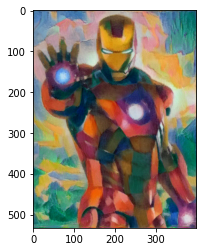

Image of iteration  5000
Total loss:  64240.1640625


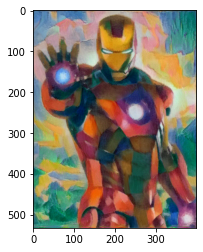

In [ ]:
# for displayng the target image, intermittently
show_every = 100

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 5000

for ii in range(1, steps+1):
    # Get the features from target image
    # Then calculate the content loss
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # initialize the style loss to 0
    style_loss = 0
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        # Calculate the target gram matrix
        target_gram = gram_matrix(target_feature)
        
        # Get the "style" style representation
        style_gram = style_grams[layer]
        # Calculate the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        # Add to the style loss
        style_loss += layer_style_loss / (d * h * w)
    
    # Calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # Update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Display intermediate images and print the loss
    if ii % show_every == 0:
        print('Image of iteration ', ii)
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

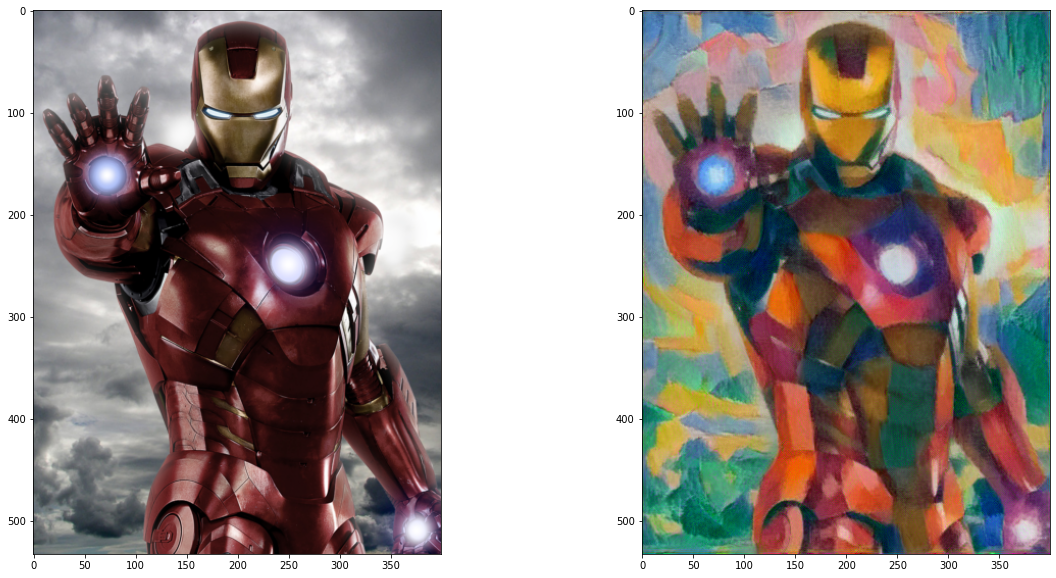

In [ ]:
# Display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))